# The Moving Average Filter
The moving average is the most common filter in DSP, mainly because it is the easiest digital filter to understand and use. In spite of its simplicity, the moving average filter is optimal for a common task: reducing random noise while retaining a sharp step response. This makes it the premier filter for time domain encoded signals. However, the moving average is the worst filter for frequency domain encoded signals, with little ability to separate one band of frequencies from another. Relatives of the moving average filter include the Gaussian, Blackman, and multiple-pass moving average. These have slightly better performance in the frequency domain, at the expense of increased computation time. 

## Implementation by Convolution
The moving average can be computed usign the following equation:
$$y[i]=\frac{1}{M} \sum\limits^{M-1}_{j=0}{x[i+j]}$$

Let's implement the moving average by convolution.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(x, M = 5, symmetry = 'sym'):
    """ 
    Function that calculates the moving average of a signal in a symmetric and asymmetric form.
  
    Parameters: 
    x (numpy array): Array of numbers representing the signal to be analyzed.
    M (integer): Number of point for the moving average filter.
    symmetry (string): String value for the type of symmetry being used, can be 'sym' or 'asym'.
  
    Returns: 
    numpy array: Returns filter response.
  
    """
    N = len(x)
    y = np.zeros(N)
    m = int(M/2)

    
    if(symmetry == 'asym'):
        for i in range(N-M):
            for j in range(M):
                y[i] = y[i] + x[i+j]
                
    elif(symmetry == 'sym'):
        for i in range(m,N-m):
            for j in range(-m,m):
                y[i] = y[i] + x[i+j]
                
    return y/M

In [2]:
x = np.loadtxt(fname = "waveforms.dat").flatten()
y_asym = moving_average(x, M=11, symmetry = 'asym')
y_sym = moving_average(x, M=11, symmetry = 'sym')

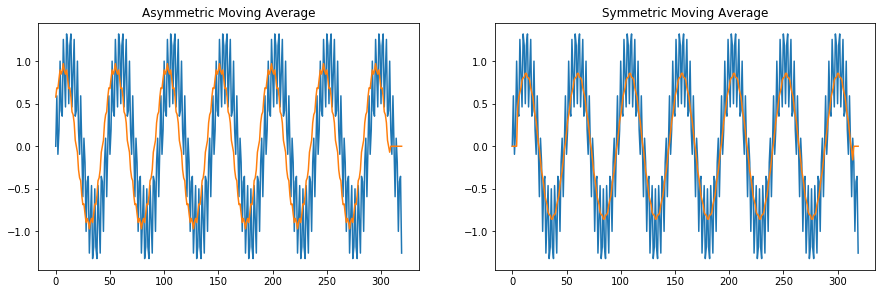

In [3]:
plt.rcParams["figure.figsize"] = (15,10)

plt.subplot(2,2,1)
plt.plot(x)
plt.plot(y_asym)
plt.title('Asymmetric Moving Average')


plt.subplot(2,2,2)
plt.plot(x)
plt.plot(y_sym)
plt.title('Symmetric Moving Average');

Now let's try to make a signal with additive gaussian noise to test how it works in removing noise from a signal:

In [30]:
t = np.arange(0,35,0.01)
signal = 1*np.sin(t)
#noise = 0.75*np.random.normal(size=len(t)) #Try to use np.random.uniform
noise = 0.75*np.random.uniform(size=len(t)) #Try to use np.random.uniform
noise_signal = signal + noise

noiseless_signal = moving_average(noise_signal, M=5, symmetry = 'asym')

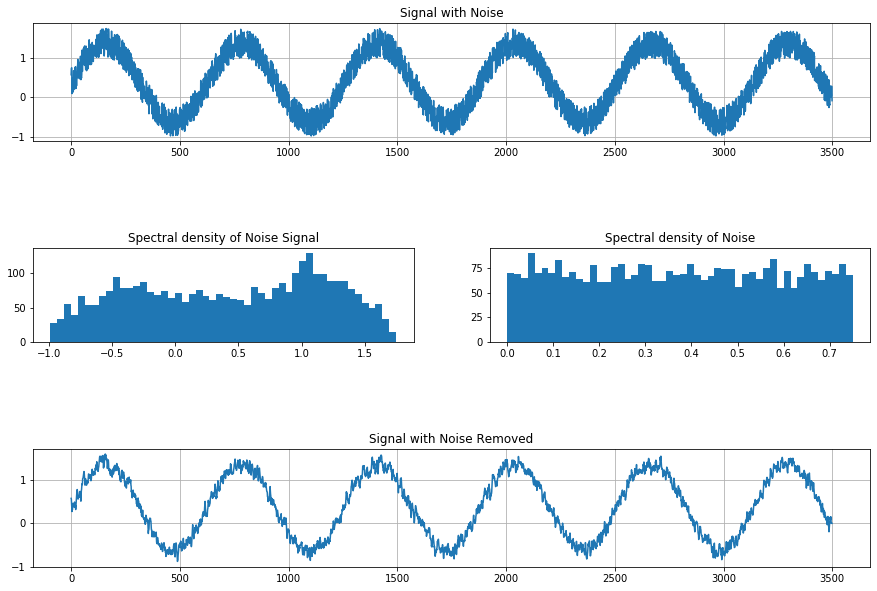

In [31]:
plt.rcParams["figure.figsize"] = (15,10)

plt.subplot(4, 1, 1)
plt.plot(noise_signal);
plt.title("Signal with Noise")
plt.grid(True)

plt.subplot(5, 2, 5)
plt.hist(noise_signal, 50);
plt.title("Spectral density of Noise Signal")

plt.subplot(5, 2, 6)
plt.hist(noise, 50)
plt.title("Spectral density of Noise")

plt.subplot(4, 1, 4)
plt.plot(noiseless_signal)
plt.title("Signal with Noise Removed")
plt.grid(True);

## Frequency Response

The frequency response of the moving average filter can be calculated by the Fourier transform of the rectangular pulse and is given by:

$$H[f]=\frac{\sin{(\pi f M)}}{M\sin{(\pi f)}} $$

The roll-off is very slow and the stopband attenuation is ghastly. Clearly, the moving average filter cannot separate one band of frequencies from another. Remember, good performance in the time domain results in poor performance in the frequency domain, and vice versa. In short, the moving average is an exceptionally good smoothing filter (the action in the time domain), but an exceptionally bad low-pass filter (the action in the frequency domain). 

In [32]:
def frequency_response(f, M):
    H = np.ones(len(f))
    H[1:] =  np.sin(np.pi*f[1:]*M)/(M*np.sin(np.pi*f[1:]))
    return H

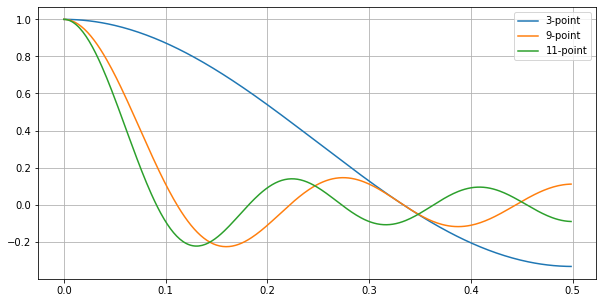

In [33]:
N = len(x)
f = np.arange(0, 0.5, 0.5/N)
m1 = 3
m2 = 9
m3 = 11

plt.rcParams["figure.figsize"] = (10,5)

H1 = frequency_response(f, m1)
H2 = frequency_response(f, m2)
H3 = frequency_response(f, m3)
plt.plot(f,H1, label='{}-point'.format(m1))
plt.plot(f,H2, label='{}-point'.format(m2))
plt.plot(f,H3, label='{}-point'.format(m3))
plt.grid(True)
plt.legend();

## Multiple-pass Moving Average Filter
Multiple-pass moving average filters involve passing the input signal through a moving average filter two or more times. Two passes are equivalent to using a triangular filter kernel (a rectangular filter kernel convolved with itself). After four or more passes, the equivalent filter kernel looks like a Gaussian (recall the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) ).

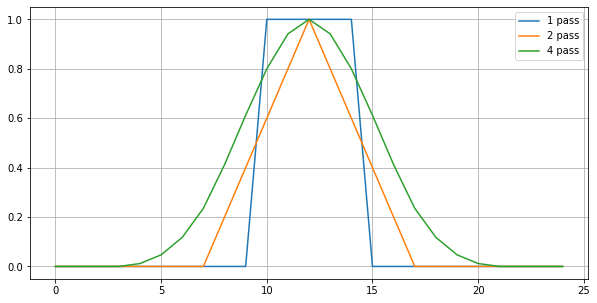

In [37]:
plt.rcParams["figure.figsize"] = (10,5)

step = np.append(np.zeros(10),np.ones(5))
step = np.append(step, np.zeros(10))

triangular = np.convolve(step,step)
gaussian = np.convolve(triangular,triangular)

plt.plot(step, label='1 pass')
plt.plot(triangular[12:-12]/np.max(triangular), label='2 pass')
plt.plot(gaussian[3*12:-3*12]/np.max(gaussian), label='4 pass')

plt.grid(True)
plt.legend();

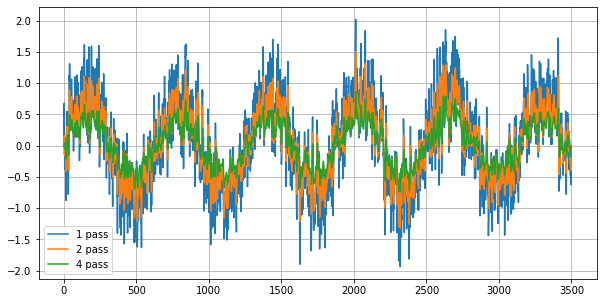

In [9]:
one_pass = moving_average(noise_signal, M=5, symmetry = 'sym')
two_pass = moving_average(one_pass, M=5, symmetry = 'sym')
three_pass = moving_average(two_pass, M=5, symmetry = 'sym')
four_pass = moving_average(three_pass, M=5, symmetry = 'sym')


plt.plot(one_pass, label='1 pass')
plt.plot(two_pass, label='2 pass')
plt.plot(four_pass, label='4 pass')

plt.grid(True)
plt.legend();

## Recursive Moving Filter
A faster implementation of the moving average filter is done by using recursion. To show this method we can imagine passing an input signal, $x[ ]$, through a seven point moving average filter to form an output signal, $y[ ]$. Now look at how two adjacent output points, $y[25]$ and $y[26]$, are calculated:


$$y[25] = x[22] + x[23] +x[24] + x[25] + x[26] + x[27] + x[28]$$

$$y[26] = x[23] +x[24] + x[25] + x[26] + x[27] + x[28] + x[29]$$

By looking at $y[25]$ and $y[26]$ we can write:

$$ y[26] = y[25] + x[29] - x[22]$$

We can even generalize as follows:

$$y[i] = y[i-1] + x[i+p] - x[i-q]$$

$$\textrm{with} \quad p = \frac{(M-1)}{2}  \quad \textrm{and}  \quad q = p + 1$$


In [38]:
def recursive_moving_average(x, M = 5):
    """ 
    Function that calculates the recursive moving average of a signal in a symmetric form.
  
    Parameters: 
    x (numpy array): Array of numbers representing the signal to be analyzed.
    M (integer): Number of point for the moving average filter.
  
    Returns: 
    numpy array: Returns filter response.
  
    """
    N = len(x)
    y = np.zeros(N)
    acc = 0

    for i in range(M):
        acc = acc + x[i]
    y[int(M/2)] = acc/M


    p = int((M-1)/2)
    q = p + 1

    for k in range(int(M/2)+1,N-int(M/2)):
        acc = acc + x[k+p] -x[k-q]
        y[k] = acc/M
        
    return y

## Comparison between Moving Average and Recursive Moving Average
The following example shows a comparison between both models and the error between them. As it can be seen, the error is a systematically one, and a further study can be developed. 

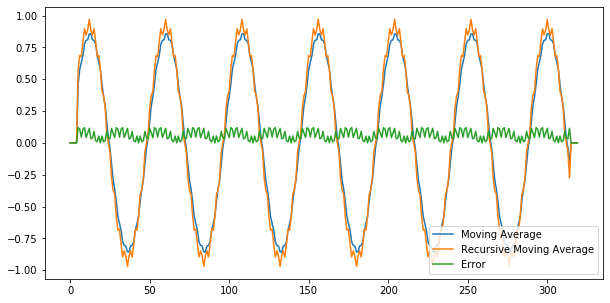

In [40]:
M = 11
y1 = moving_average(x, M = M, symmetry = 'sym')
y2 = recursive_moving_average(x, M = M)

plt.plot(y1, label = 'Moving Average')
plt.plot(y2, label = 'Recursive Moving Average')
plt.plot(np.abs(y1-y2), label = 'Error')
plt.legend()